In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_damped_SHM_data, get_damped_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_damped_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [55]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 150
max_v = 10
n_train = 3 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_pendulum_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[ 89.683  114.6104 -60.8628]
[ 8.5369 -8.7404 -7.7737]


In [68]:
moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-5
invar_density = 20
latex=""
try:
    kernel = get_damped_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
    known = get_GPR_model(kernel, mean, data, 500)
    print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
    i = 0
    for poly_f_d in [3]:
        for poly_g_d in [4]:
            kernel = get_damped_polynomial_invariance(np.radians(150), invar_density, jitter, poly_f_d, poly_g_d) #switch
            m = get_GPR_model(kernel, mean, data, 3000)
            print("(%s, %s)----------------------"%(poly_f_d-1, poly_g_d-1))
            np.set_printoptions(precision=4)
            print(kernel.f_poly.numpy())
            print(kernel.g_poly.numpy())
            print(format(m.log_marginal_likelihood().numpy(),".2f"))
            latex+=format(m.log_marginal_likelihood().numpy(),".2f")
            i+=1
            if i%9==0:
                latex+='\\'
            else:
                latex+="&"
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi:226.09
known: 239.48
(2, 3)----------------------
[[-1.0080e-04]
 [ 1.2538e-01]
 [-1.3275e-02]]
[[-0.0025]
 [ 0.1203]
 [-0.0033]
 [-0.014 ]]
239.57


In [58]:
latex

'226.08&226.08&218.59&218.16&221.86&219.11&225.99&223.57&215.04\\-112049.02&225.45&218.52&220.35&223.26&221.92&240.04&231.61&225.89\\221.63&223.61&215.57&212.95&211.57&nan&222.00&222.51&218.68\\212.60&-77.94&-49457.89&215.94&225.39&223.42&-84.95&215.23&225.66\\'

In [51]:
import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future

In [71]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

grids = (np.radians(150), 40)
dynamics = damped_pendulum_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = m.log_marginal_likelihood().numpy()

grid_moi = (evaluate_model_grid(moi, grids, dynamics))
grid_inv = (evaluate_model_grid(known, grids, dynamics))
grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
print(lml_inv_p)

for i in range(3):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting)
    eva_future_moi.append(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting)
    eva_future_inv.append(evaluate_invariance[0])

    if i==2:
        evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    else:
        evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting)
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance[0])


226.08510693782043
239.4773021191438
239.56691187847105
0
0.04640424812466061
1
0.046518792474602874
2
0.035306042006590065


In [72]:
print("Baseline RBF & " + format((lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format((grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format((lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((grid_inv),".4f")+ ' \\\\')
print("Parameterised Invariance Kernel & "+ format((lml_inv_p),".2f")+" & "+format(np.mean(eva_future_inv_p),".4f")+" & "+format((grid_inv_p),".4f")+ ' \\\\')

Baseline RBF & 226.09 & 0.2235 & 0.9067 \\
Invariance Kernel & 239.48 & 0.0427 & 0.2136 \\
Parameterised Invariance Kernel & 239.57 & 0.0704 & 0.0705 \\


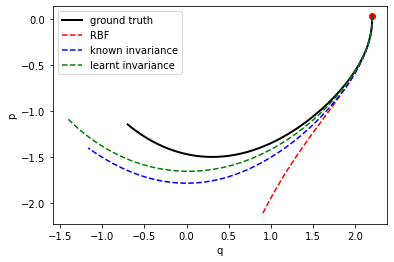

In [74]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/parameterised_damped_pendulum_predicted_trajectory.pdf")

In [39]:
import matplotlib.pyplot as plt

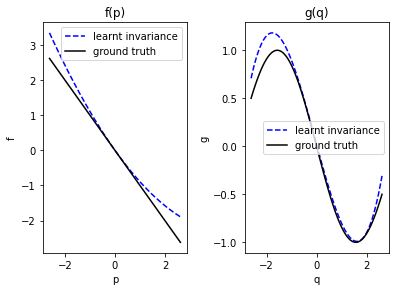

In [75]:

from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -np.sin(x), color="black", label='ground truth')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/parameterised_damped_pendulum_learnt_polynomial.pdf")



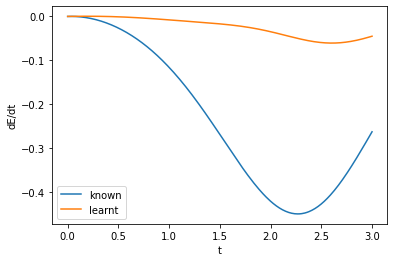

In [77]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance_p[5]), label="known")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6]), label="learnt")
plt.legend()
plt.xlabel("t")
plt.ylabel("dE/dt")
plt.savefig("figures/parameterised_damped_pendulum_conservation_of_energy.pdf")